In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
import seaborn as sns
import random

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score

In [113]:
from time import time
def runtime(t0):
    dt = time() - t0
    if dt < 60:
        message = f'{dt:.0f} sec.'
    elif dt < 3600:
        message = f'{dt/60:.0f} min.'
    else:
        h = int(dt//3600)
        m = int((dt%3600) / 60)
        message = f'{h} h. {m} min.'
    print(message)
    
def dround(x, dec=2):
    x += 1e-9
    return float(f'{x:.{dec}f}')

def xminmax(ax, offset=0.05):
    axis = ax.axis()
    xmin, xmax = min(axis[0], axis[2]), max(axis[1], axis[3])
    
    xmin -= (xmax-xmin)*offset
    xmax += (xmax-xmin)*offset
    return xmin, xmax

In [377]:
design_name = 'Quantitative'
# design_name = 'Formulation'
df = pd.read_excel('data/Experimental-Designs.xlsx', sheet_name=design_name)
df

,Exp Name,x1,x2,x3,x4
0,N1,0.10,0.150,0.2,0.000
1,N2,0.60,0.150,0.2,0.000
2,N3,0.10,0.700,0.2,0.000
3,N4,0.60,0.700,0.2,0.000
4,N5,0.60,0.150,0.8,0.000
5,N6,0.10,0.700,0.8,0.000
6,N7,0.60,0.700,0.8,0.000
7,N8,0.10,0.150,0.2,0.750
8,N9,0.60,0.700,0.2,0.750
9,N10,0.10,0.150,0.8,0.750


In [378]:
def function(x1,x2,x3,x4, theta, noise):
    random.seed(123)
    return theta[0] + theta[1]*x1 + theta[2]*x2 + theta[3]*x3 + theta[4]*x4 + theta[5]*x1*x2 \
            + theta[6]*x1*x3 + theta[7]*x1*x4 + theta[8]*x2*x3 + theta[9]*x2*x4 + theta[10]*x3*x4 + np.random.normal(loc=0, scale=noise, size=len(x1))

In [379]:
random.seed(1234)
theta_vals = []
for _ in range(3):
    theta_vals.append([random.randint(-100,100)/10 for _ in range(11)])
theta1, theta2, theta3 = theta_vals
theta1[5:] = [0]*(len(theta1)-5)
theta1

[9.9, 1.2, -7.1, -9.9, -7.7, 0, 0, 0, 0, 0, 0]

In [380]:
# theta1 = [4,1,2,-0.1,0.9,0,0,0,0,0,0]
# theta2 = [-4,1,2,0.1,-0.5,0,1.3,3,5.5,-2.5,0]
# theta3 = [8,0.1,20.3,6.5,0.5,10.3,-1.5,-2.3,-1.6,2.3,40.2]
sigma0 = 0.95
df['y1'] = function(x1=df['x1'], x2=df['x2'], x3=df['x3'], x4=df['x4'], theta=theta1, noise=sigma0)
df['y2'] = function(x1=df['x1'], x2=df['x2'], x3=df['x3'], x4=df['x4'], theta=theta2, noise=sigma0)
df['y3'] = function(x1=df['x1'], x2=df['x2'], x3=df['x3'], x4=df['x4'], theta=theta3, noise=sigma0)

In [381]:
df
# df.to_csv('data.csv')

,Exp Name,x1,x2,x3,x4,y1,y2,y3
0,N1,0.10,0.150,0.2,0.000,7.707660,6.504091,-2.697285
1,N2,0.60,0.150,0.2,0.000,7.739604,4.536616,-6.197312
2,N3,0.10,0.700,0.2,0.000,2.904572,4.929010,-4.982096
3,N4,0.60,0.700,0.2,0.000,3.836656,1.747516,-12.072036
4,N5,0.60,0.150,0.8,0.000,3.600855,0.953722,-12.775718
5,N6,0.10,0.700,0.8,0.000,-5.021288,1.550671,-8.589885
6,N7,0.60,0.700,0.8,0.000,-3.241509,-1.671770,-17.846984
7,N8,0.10,0.150,0.2,0.750,2.999813,2.620574,4.152315
8,N9,0.60,0.700,0.2,0.750,-2.231719,-1.102388,-7.597167
9,N10,0.10,0.150,0.8,0.750,-5.275788,0.263103,-4.462503


In [389]:
factors = ['x1', 'x2', 'x3', 'x4']
responses = ['y1', 'y2', 'y3']
X = df[factors].values
Y = df[responses].values

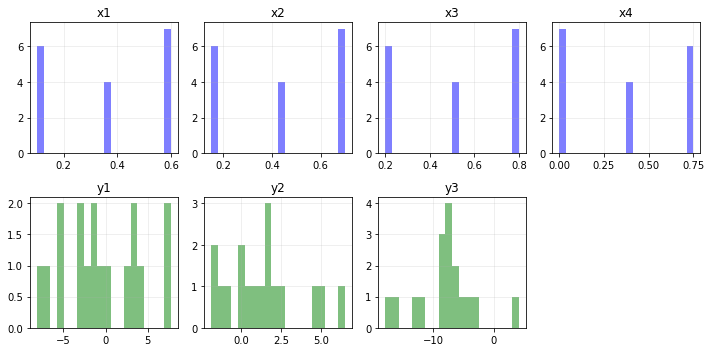

In [383]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
color = 'b'

for idx, ax in enumerate(axs.flat):
    if idx < len(factors+responses):
        if idx >= len(factors):
            color = 'g'
        col = (factors+responses)[idx] 
        ax.hist(df[col], color=color, bins=20, alpha=0.5)
        ax.set_title(col)
        ax.grid(lw=1, alpha=0.2, zorder=-5)
    else:
        fig.delaxes(ax)
plt.tight_layout()
# fig.savefig(plots_path + 'distributions-gypsum.pdf', bbox_inches='tight')

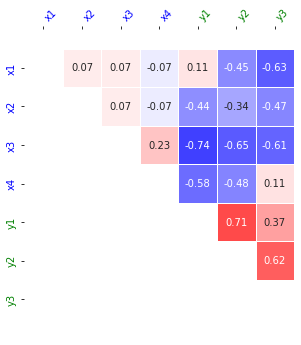

In [384]:
side = len(factors+responses)*0.7
fig, axs = plt.subplots(figsize=(side, side))
corr = df[factors+responses].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool)).T
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='bwr', cbar=False,#cbar_kws=None,#{"shrink": 0.52},
                 mask=mask, square=True, linewidths=.5, annot=True, fmt='.2f')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
for i in range(len(factors)):
    ax.get_xticklabels()[i].set_color("blue")
    ax.get_yticklabels()[i].set_color("blue")
for i in range(len(factors), len(factors)+len(responses)):
    ax.get_xticklabels()[i].set_color("green")
    ax.get_yticklabels()[i].set_color("green")
plt.tight_layout()
# fig.savefig(plots_path + 'correlation-matrix-cement.pdf', bbox_inches='tight')

y2: 0 
y3: 6 7 12 


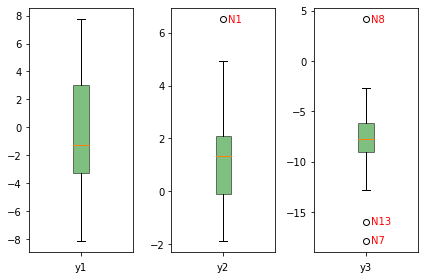

In [385]:
width = len(responses)*2
fig, axs = plt.subplots(nrows=1, ncols=len(responses), figsize=(width, 4))
for idx, r in enumerate(responses):
    ax = axs.flat[idx]
    nan_rows = df[pd.isna(df[r])].index
    if len(nan_rows) > 0:
        print(r, nan_rows)
    y = df[r].drop(nan_rows).values
    ax.boxplot(y, patch_artist=True, boxprops=dict(facecolor='g', alpha=0.5))
    ax.set(xlabel=r, xticklabels=([]))
    
    q1, q3 = np.quantile(y, 0.25), np.quantile(y, 0.75)
    iqr = q3 - q1  # iqr is interquartile range
    outlier_idxs = df[(df[r] <= q1 - 1.5 * iqr) | (df[r] >= q3 + 1.5 *iqr)].index
    n_outliers = len(outlier_idxs)
    if n_outliers > 0:
        print(r, end=': ')
        for i in outlier_idxs:
            print(i, end=' ')
            ax.text(1.05, df[r][i], df['Exp Name'].loc[i], color='r', va='center')
        print()
if idx == len(responses):
    fig.delaxes(ax)
plt.tight_layout()
# fig.savefig('../plots/20210923/distributions-Mw-PDI.pdf', bbox_inches='tight')

#### Note: points can be far from the wiskers despite noise-free data!

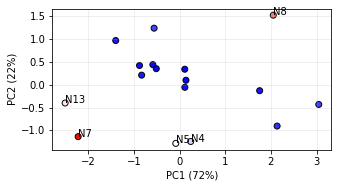

In [386]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
num_components = 2
pca = PCA(n_components=num_components)
X_znorm = StandardScaler().fit_transform(df[responses])
X_pca = pca.fit_transform(X_znorm)
explained_variance = pca.explained_variance_ratio_

distance2 = np.zeros(X_pca.shape[0])
for i in range(num_components):
    distance2 += (X_pca[:,i] - np.mean(X_pca[:,:num_components]))**2
d_euclidean = np.sqrt(distance2)

from sklearn.covariance import EmpiricalCovariance, MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(X_pca[:,:num_components])
# Get the Mahalanobis distance
d_mahalanobis = robust_cov.mahalanobis(X_pca[:,:num_components])

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(5, 5)
ax.set_aspect('equal')
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.975, c=d_mahalanobis, cmap='bwr', edgecolors='k')
ax.set(xlabel=f'PC1 ({explained_variance[0]*100:.0f}%)', 
       ylabel=f'PC2 ({explained_variance[1]*100:.0f}%)',
       # xlim=[-3,3], ylim=[-3,3]
      )
ax.grid(lw=1, alpha=0.2, zorder=-5)
for i, d in enumerate(d_mahalanobis):
    if d > 15:
        ax.text(X_pca[i, 0], X_pca[i, 1], df['Exp Name'][i])

In [390]:
model = LinearRegression()#fit_intercept=False)
Yp = cross_val_predict(model, X, Y, cv=X.shape[0])
print(f'Q^2: {np.round(r2_score(Y, Yp, multioutput="raw_values"), 2)}')
model.fit(X, Y)
# model.intercept_[0], 
model.coef_[0,:], theta1[:5]

Q^2: [0.92 0.72 0.88]


(array([  2.58448091,  -8.92085534, -10.49643134,  -6.63870566]),
 [9.9, 1.2, -7.1, -9.9, -7.7])

In [391]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


pipe = Pipeline(steps=[("poly", PolynomialFeatures()), ("pls", PLSRegression())])
print(pipe.get_params())

num_factors = len(factors)
num_responses = len(responses)
D, M = num_factors, num_responses

params = []
for n in range(2, num_factors + 1):
    params.append(
        {
            "poly__degree": 1,
            "poly__interaction_only": False,
            "pls__n_components": n,
        }
    )
for n in range(2, num_factors + num_factors * (num_factors - 1) // 2 + 1):
    params.append(
        {
            "poly__degree": 2,
            "poly__interaction_only": True,
            "pls__n_components": n,
        }
    )
# for n in range(2, num_factors + num_factors * (num_factors + 1) // 2 + 1):
#     params.append(
#         {
#             "poly__degree": 2,
#             "poly__interaction_only": False,
#             "pls__n_components": n,
#         }
#     )
len(params)

{'memory': None, 'steps': [('poly', PolynomialFeatures()), ('pls', PLSRegression())], 'verbose': False, 'poly': PolynomialFeatures(), 'pls': PLSRegression(), 'poly__degree': 2, 'poly__include_bias': True, 'poly__interaction_only': False, 'poly__order': 'C', 'pls__copy': True, 'pls__max_iter': 500, 'pls__n_components': 2, 'pls__scale': True, 'pls__tol': 1e-06}


12

X: (17, 4), Y: (17, 3), params: 12
factors: ['x1', 'x2', 'x3', 'x4']
0 1 2 3 4 5 6 7 8 9 10 11 


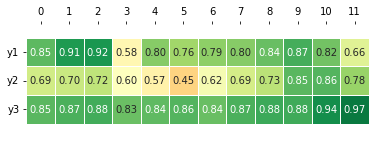

In [392]:
from helpers_jsd import fit_PLS, plot_dq2


# Y = np.log10(Y+1)
print(f'X: {X.shape}, Y: {Y.shape}, params: {len(params)}')
print(f'factors: {factors}')
dq2 = fit_PLS(responses, X, Y, params, pipe)
print()
plot_dq2(dq2, params, responses)

In [393]:
best = 2  # manually selected
params[best]

{'poly__degree': 1, 'poly__interaction_only': False, 'pls__n_components': 4}

In [394]:
pipe.set_params(**params[best])

pipe.fit(X, Y)
Ypr= pipe.predict(X)
r2 = r2_score(Y, Ypr, multioutput="raw_values")
Yp = cross_val_predict(pipe, X, Y, cv=X.shape[0])
q2 = r2_score(Y, Yp, multioutput="raw_values")

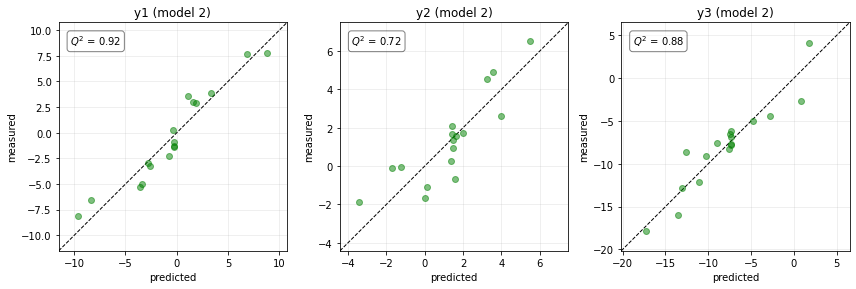

In [395]:
ncols, nrows = len(responses), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for i, ax in enumerate(axs.flat):
    ax.scatter(Yp[:,i], Y[:,i], color='g', alpha=0.5, zorder=3)
    ax.set(title=f'{responses[i]} (model {best})', xlabel='predicted', ylabel='measured')
    ax.grid(lw=1, alpha=0.2, zorder=0)
    ax.set_aspect('equal')
    xmin, xmax = xminmax(ax)
    line = [xmin, xmax]
    ax.plot(line, line, 'k--', lw=1)
    ax.set(xlim=[xmin,xmax], ylim=[xmin,xmax])
    if q2[i] > 0:
        text_box = f'$Q^2$ = {q2[i]:.2f}'
    else:
        text_box = f'$Q^2<0$'
    ax.text(0.05, 0.95, text_box, transform=ax.transAxes, #fontsize=14,
            verticalalignment='top', bbox={'boxstyle':'round', 'facecolor':'w', 'alpha':0.5})
    for j, (xp, xm, name) in enumerate(zip(Yp[:,i], Y[:,i], df['Exp Name'])):
        if np.abs(xp-xm) > (xmax-xmin)*0.2:
            ax.text(xp, xm, name, color='r', fontsize=12)
fig.tight_layout()
# fig.savefig(path_plots + 'models-cement-HydrationHeat(48h).pdf', bbox_inches='tight')
# fig.savefig(path_plots + 'models-cement-EndDormantPhase.pdf', bbox_inches='tight')

# PYMC

In [333]:
import arviz as az
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [396]:
# use actual data (1:10:00)
with pm.Model() as model:
    t0, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10 = [pm.Normal("t"+str(i), mu=0, sd=10) for i in range(11)]
    sigma = pm.Uniform("sigma", 0, 10)
    x1, x2, x3, x4, y = df['x1'], df['x2'], df['x3'], df['x4'], df['y2']
    mu = t0 + t1*x1 + t2*x2 + t3*x3 + t4*x4 + t5*x1*x2 + t6*x1*x2 + t7*x1*x4 + t8*x2*x3 + t9*x2*x4 + t10*x3*x4
    y1 = pm.Normal("y1", mu=mu, sd=sigma, observed=y)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, t10, t9, t8, t7, t6, t5, t4, t3, t2, t1, t0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7141244153454668, but should be close to 0.8. Try to increase the number of tuning steps.
There were 255 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6462818277146025, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [397]:
# plt.figure(figsize=(7, 7))
# pm.traceplot(trace)
# plt.tight_layout();

In [398]:
# df_pm = pm.trace_to_dataframe(trace).round(3)

In [399]:
az.summary(trace, round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,7.93,1.45,5.38,10.71,0.11,0.08,170.04,333.27,1.02
t1,-2.38,2.74,-7.13,2.85,0.18,0.13,204.61,520.89,1.00
t2,-2.17,2.73,-6.83,3.14,0.24,0.18,139.94,307.40,1.01
t3,-6.33,2.45,-10.94,-1.98,0.22,0.16,122.68,156.39,1.01
t4,-6.00,2.26,-10.34,-1.67,0.13,0.09,284.41,563.89,1.01
t5,-2.70,7.02,-14.99,11.11,0.65,0.46,121.54,196.75,1.00
t6,-2.57,6.93,-15.54,9.99,0.64,0.45,117.06,217.06,1.01
t7,2.21,2.90,-3.52,7.51,0.15,0.11,329.51,762.86,1.01
t8,1.42,3.80,-4.94,9.58,0.32,0.23,138.95,111.78,1.04
t9,0.53,3.09,-4.98,6.65,0.28,0.20,118.24,327.53,1.01


In [364]:
theta1

[9.9, 1.2, -7.1, -9.9, -7.7, 0, 0, 0, 0, 0, 0]

In [400]:
true_vals = {}
for i, v in enumerate(theta2):
    true_vals['t'+str(i)] = v
true_vals['sigma'] = 0.93

Got error No model on context stack. trying to find log_likelihood in translation.


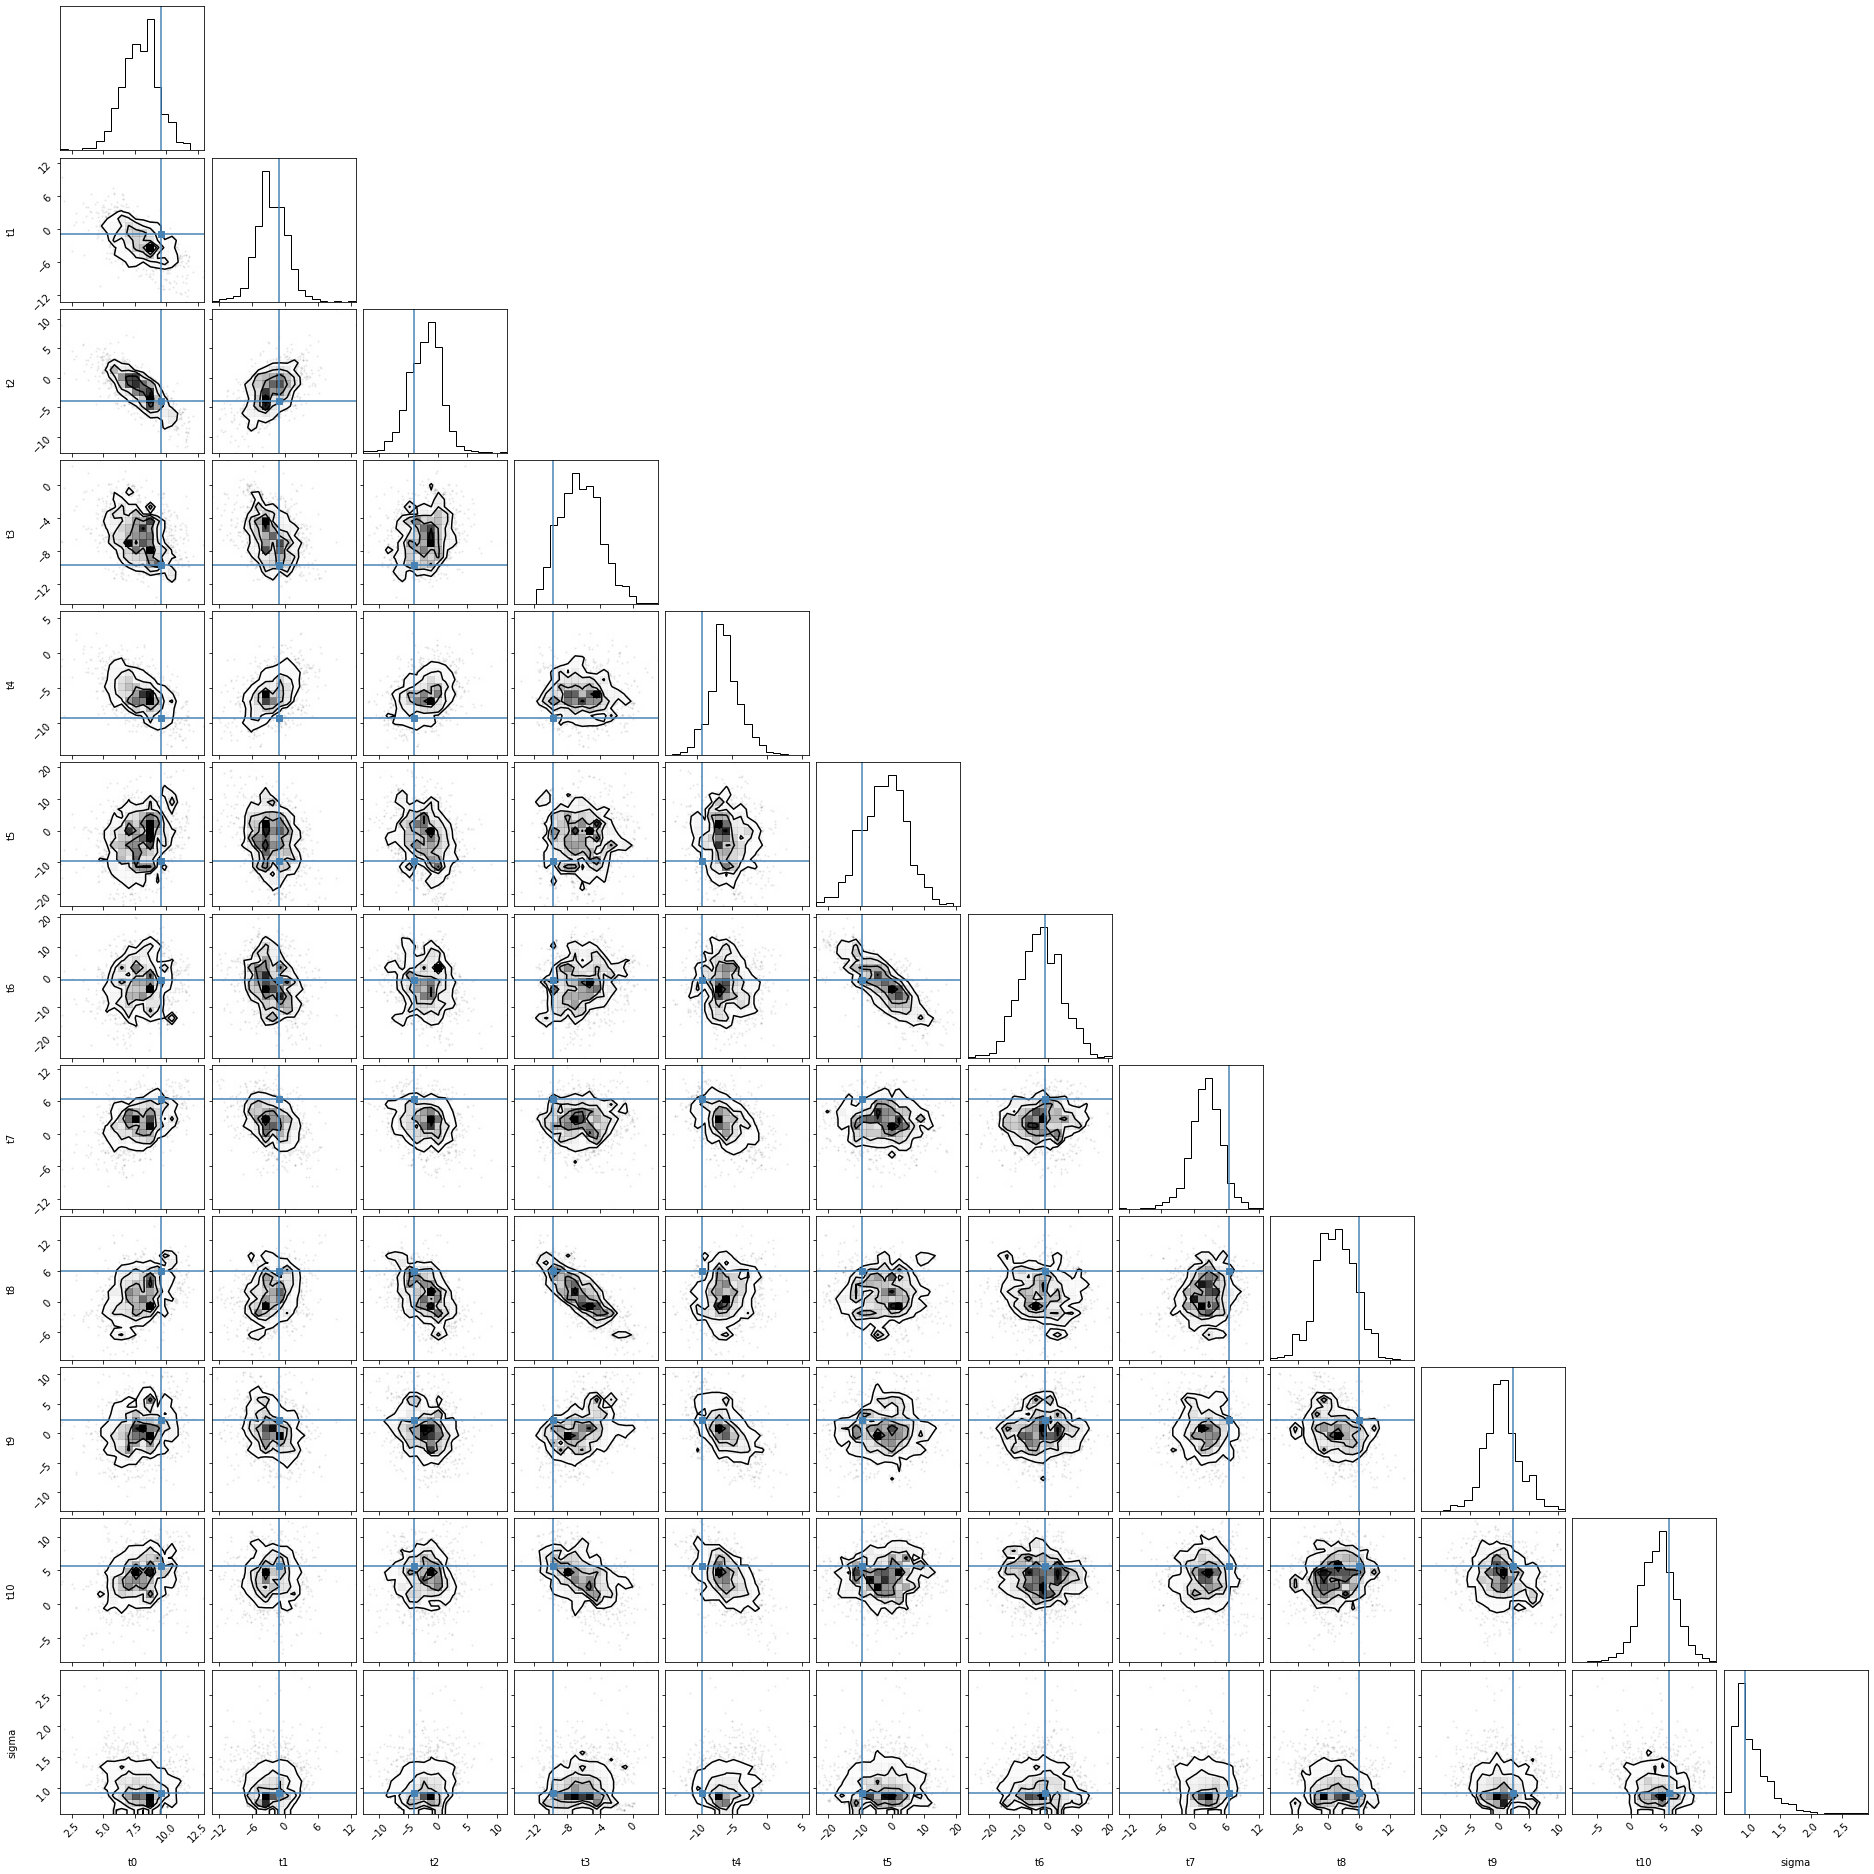

In [401]:
import corner
_ = corner.corner(trace, truths=true_vals,)